In [1]:
import jax
import jax.numpy as np
from scipy.stats import wasserstein_distance
from functools import partial
import matplotlib.pyplot as plt

In [2]:
def constraint(x):
    return np.array([
        (1. - np.sqrt((x ** 2).sum())) ** 2,
    ])

def constraint_parametric(t):
    return np.array([np.cos(2 * np.pi * t), np.sin(2 * np.pi * t)])

mean = np.array([0., 1.])
cov = np.array([
    [1., 0.],
    [0., 1.],
])
pdf = partial(jax.scipy.stats.multivariate_normal.pdf, mean=mean, cov=cov)

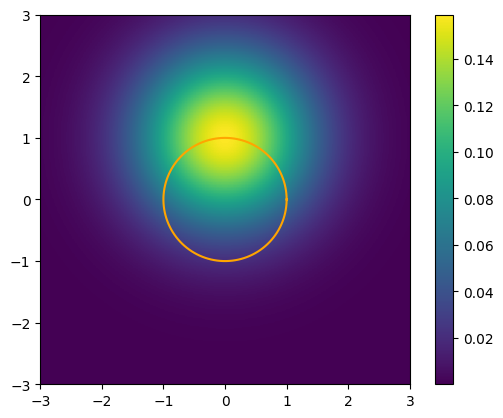

In [3]:
# visualize
t = np.linspace(0., 1., 256)
manifold = jax.vmap(constraint_parametric)(t)

grid = np.linspace(-3, 3, 128)
ii, jj = np.meshgrid(grid, grid)

xx = np.stack([ii, jj], -1)
pp = jax.vmap(jax.vmap(pdf))(xx)

fig, ax = plt.subplots()
im = ax.imshow(pp, origin='lower', extent=[-3, 3, -3, 3])
fig.colorbar(im)

ax.plot(manifold[:, 0], manifold[:, 1], 'orange')

plt.show()

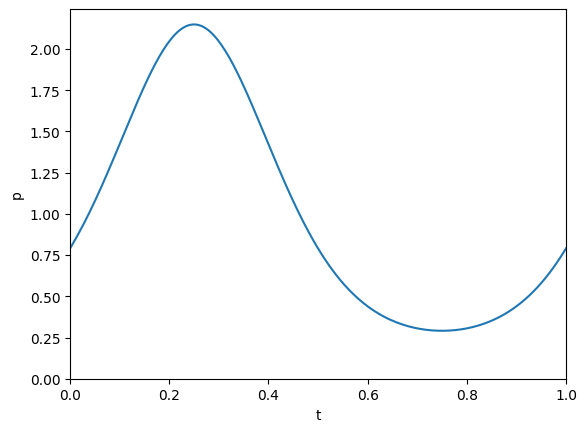

In [4]:
numerical_pdf = jax.vmap(pdf)(manifold)
numerical_pdf = numerical_pdf / numerical_pdf.sum() * len(t)

fig, ax = plt.subplots()
ax.plot(t, numerical_pdf)
ax.set_xlim(0, 1)
ax.set_ylim(ymin=0)
ax.set_xlabel('t')
ax.set_ylabel('p')
plt.show()

## Naive rejection sampling

In [5]:
@jax.jit
def x_to_angle(x):
    theta = np.arctan2(x[1], x[0])
    theta %= (2 * np.pi)
    p = theta / (2 * np.pi)
    return p

def project(x):
    # only works for quadratic constraints!
    dx = jax.jacobian(constraint)(x)[0]
    return x - .5 * dx

def naive_rejection(num_samples, random_key, epsilon=.5):
    @jax.jit
    def take_sample(random_key):
        random_key, key = jax.random.split(random_key, 2)
        x = jax.random.multivariate_normal(key, mean, cov)
        c = constraint(x)
        x = project(x)
        return random_key, np.abs(c) < epsilon, x

    samples = []
    total_samples = 0
    while len(samples) < num_samples:
        total_samples += 1
        random_key, decision, x = take_sample(random_key)
        if decision:
            samples.append(x_to_angle(x))
    samples = np.array(samples)
    return samples, total_samples

def metropolis_hastings(num_samples, random_key, sigma_step, burn_in=100):
    # https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm
    @jax.jit
    def sample(random_key, x):
        random_key, key_0, key_1 = jax.random.split(random_key, 3)
        x_new = jax.random.multivariate_normal(key_0, x, sigma_step * np.eye(2))
        x_new = project(x_new)
        alpha = pdf(x_new) / pdf(x)
        return random_key, alpha >= jax.random.uniform(key_1), x_new

    x = project(mean) # init x
    samples = []
    total_samples = 0
    while len(samples) < num_samples + burn_in:
        random_key, decision, x_new = sample(random_key, x)
        total_samples += 1
        if decision:
            x = x_new
            samples.append(x_to_angle(x))
    samples = np.array(samples[burn_in:])
    return samples, total_samples

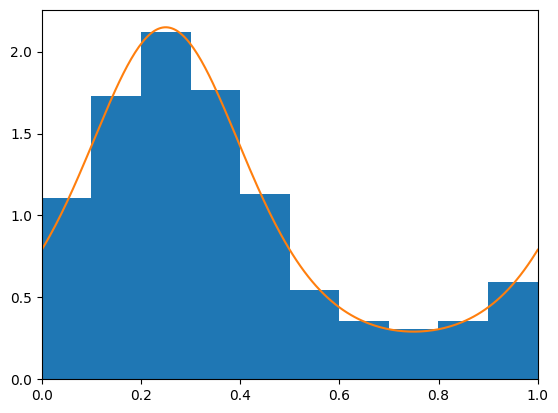

[n-.03] Wasserstein distance: 0.002, total samples / accepted samples: 62308/10000 (6.23)


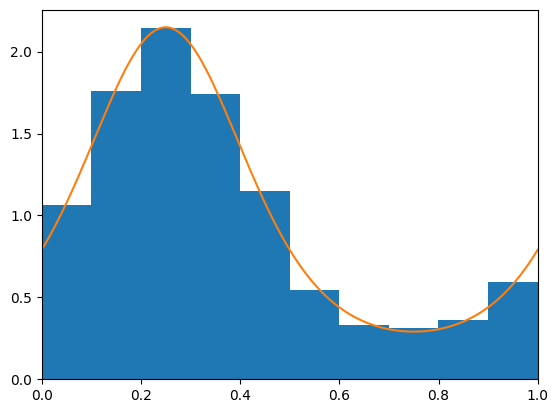

[n-.1] Wasserstein distance: 0.002, total samples / accepted samples: 35511/10000 (3.55)


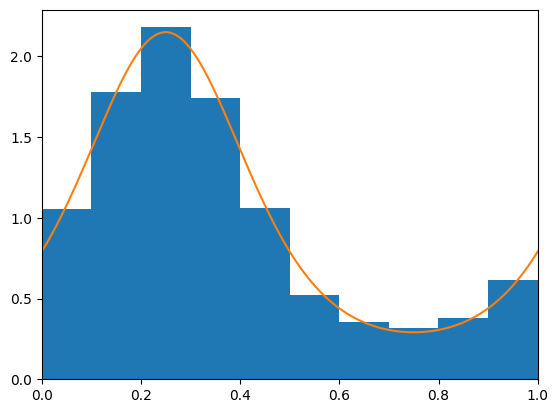

[n-.3] Wasserstein distance: 0.004, total samples / accepted samples: 21340/10000 (2.13)


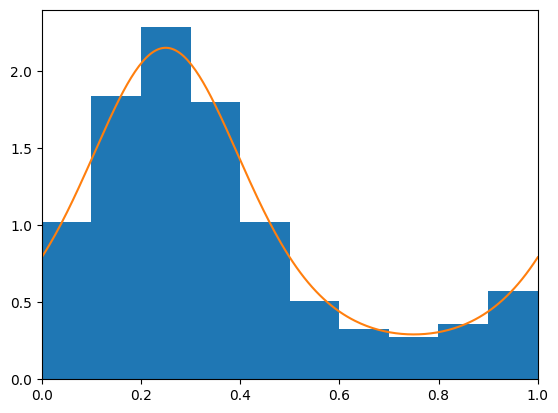

[n-1.] Wasserstein distance: 0.009, total samples / accepted samples: 13659/10000 (1.37)


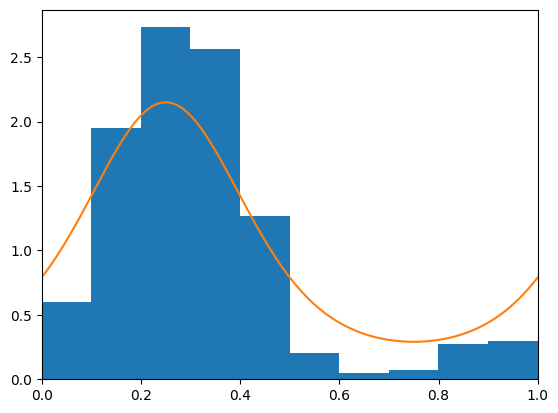

[mh-.01] Wasserstein distance: 0.058, total samples / accepted samples: 10333/10000 (1.03)


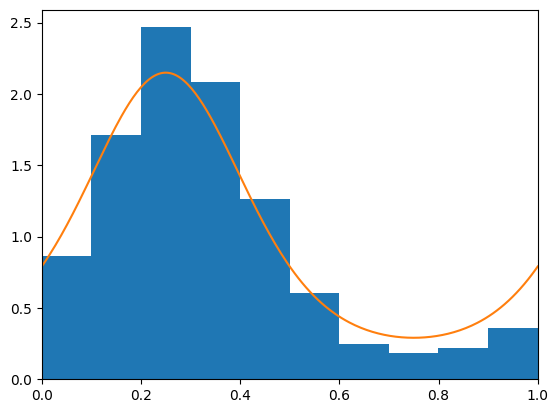

[mh-.03] Wasserstein distance: 0.034, total samples / accepted samples: 10546/10000 (1.05)


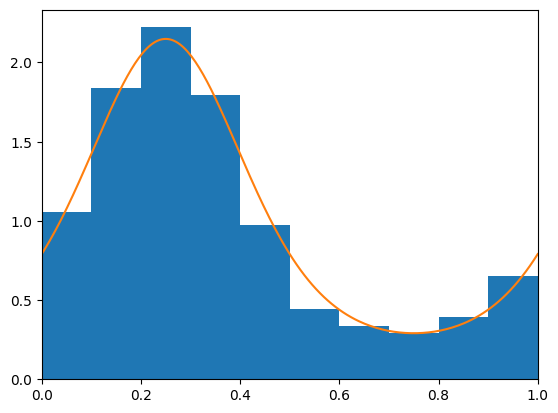

[mh-.1] Wasserstein distance: 0.008, total samples / accepted samples: 10933/10000 (1.09)


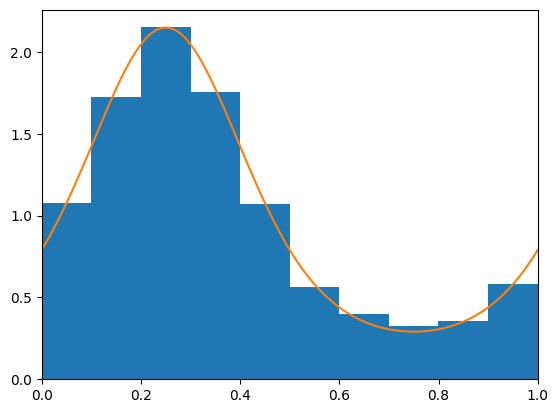

[mh-.3] Wasserstein distance: 0.002, total samples / accepted samples: 11769/10000 (1.18)


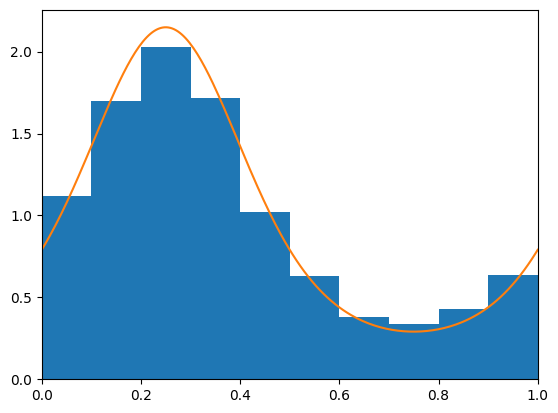

[mh-1.] Wasserstein distance: 0.010, total samples / accepted samples: 12992/10000 (1.30)


In [6]:
experiments = {
    'n-.03': partial(naive_rejection, epsilon=.03),
    'n-.1': partial(naive_rejection, epsilon=.1),
    'n-.3': partial(naive_rejection, epsilon=.3),
    'n-1.': partial(naive_rejection, epsilon=1.),
    'mh-.01': partial(metropolis_hastings, sigma_step=.01),
    'mh-.03': partial(metropolis_hastings, sigma_step=.03),
    'mh-.1': partial(metropolis_hastings, sigma_step=.1),
    'mh-.3': partial(metropolis_hastings, sigma_step=.3),
    'mh-1.': partial(metropolis_hastings, sigma_step=1.),
}
samples, total_samples = naive_rejection(10000, jax.random.PRNGKey(42), epsilon=.5)
num_samples = 10000
results = []
for name, experiment in experiments.items():
    samples, total_samples = experiment(num_samples, jax.random.PRNGKey(43))
    distance = wasserstein_distance(t, samples, numerical_pdf)
    results.append((name, total_samples / len(samples), distance))

    fig, ax = plt.subplots()
    ax.hist(samples, density=True)
    ax.plot(t, numerical_pdf)
    ax.set_xlim(0, 1)
    ax.set_ylim(ymin=0)
    plt.show()

    print(f'[{name}] Wasserstein distance: {distance:.3f}, total samples / accepted samples: {total_samples}/{len(samples)} ({total_samples / len(samples):.2f})')

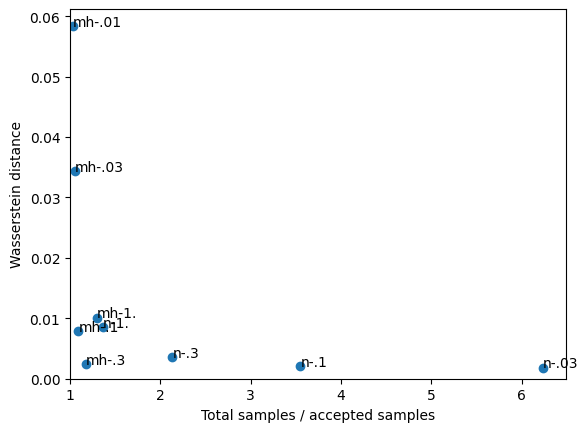

In [7]:
names, ratios, distances = zip(*results)

fig, ax = plt.subplots()
ax.scatter(ratios, distances)
ax.set_ylim(ymin=0)
ax.set_xlim(xmin=1)
ax.set_xlabel('Total samples / accepted samples')
ax.set_ylabel('Wasserstein distance')

for name, ratio, distance in results:
    ax.annotate(name, (ratio, distance))

plt.show()